In [2]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


## **Importing Libraries**

In [3]:
import math
import random
import numpy as np
import pandas as pd
import seaborn as sns
import tensorflow as tf
import statsmodels.api as sm
import statsmodels.formula.api as smf
import matplotlib.pyplot as plt
import sklearn.metrics as metrics
import tensorflow as tf

from datetime import datetime
from matplotlib.pylab import rcParams
from statsmodels.tsa.stattools import kpss

from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split

from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.initializers import RandomNormal, Constant
from tensorflow.keras.layers import LSTM, Dense, Dropout, TimeDistributed, Bidirectional

import warnings
warnings.filterwarnings('ignore')

tf.random.set_seed(42)

## **Reading and Pre-processing Stock Data**

In [4]:
stock_data = pd.read_csv('/content/gdrive/MyDrive/Stock Market Prediction - Time Series/AAPL.csv')

In [5]:
stock_data

,Date,Open,High,Low,Close,Adj Close,Volume
0,2010-04-01,8.478929,8.526071,8.312500,8.427500,7.134717,603145200
1,2010-04-05,8.392143,8.518214,8.384643,8.517500,7.210913,684507600
2,2010-04-06,8.507143,8.580000,8.464286,8.555000,7.242660,447017200
3,2010-04-07,8.555357,8.640000,8.523571,8.592857,7.274709,628502000
4,2010-04-08,8.587143,8.626429,8.501429,8.569643,7.255055,572989200
...,...,...,...,...,...,...,...
3452,2023-12-18,196.089996,196.630005,194.389999,195.889999,195.640350,55751900
3453,2023-12-19,196.160004,196.949997,195.889999,196.940002,196.689026,40714100
3454,2023-12-20,196.899994,197.679993,194.830002,194.830002,194.581711,52242800
3455,2023-12-21,196.100006,197.080002,193.500000,194.679993,194.431885,46482500


We see that the data has a total of 3457 rows and 7 features.

In [6]:
FIGURE_SIZE = (10, 8)
plt.rcParams['axes.grid'] = True

<Axes: xlabel='Date'>

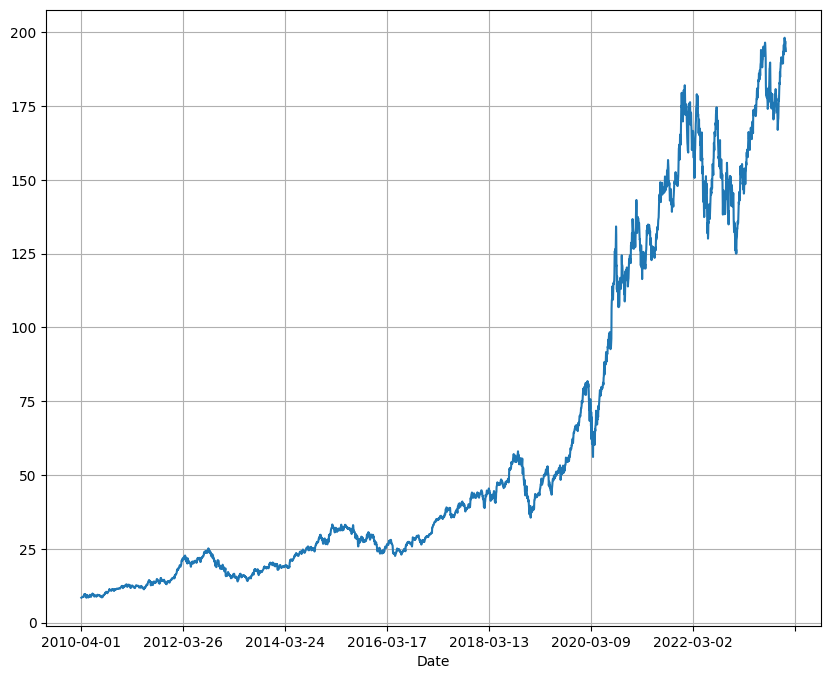

In [7]:
stock_data.set_index('Date')['Close'].plot(figsize=FIGURE_SIZE)

<Axes: xlabel='Date'>

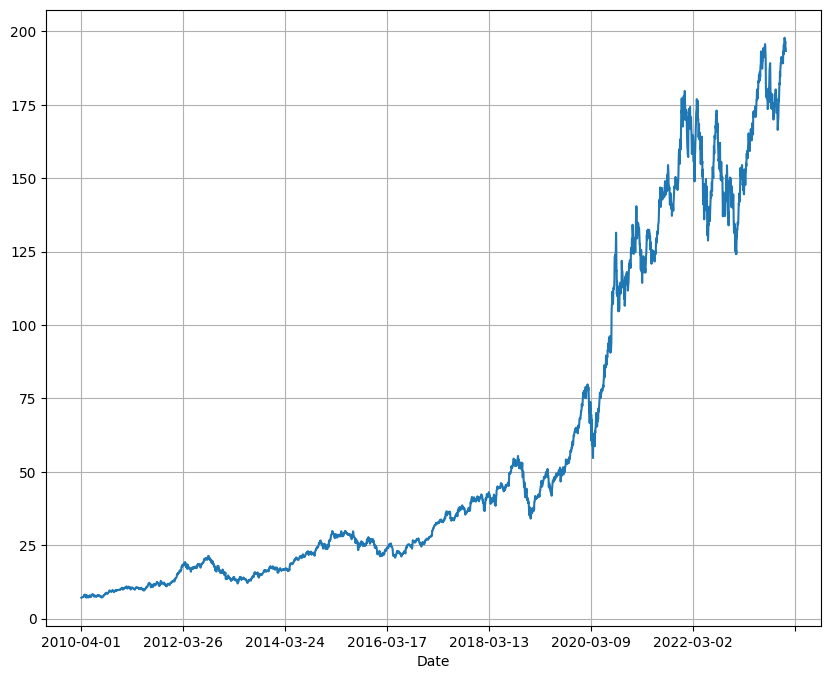

In [8]:
stock_data.set_index('Date')['Adj Close'].plot(figsize=FIGURE_SIZE)

In [9]:
def data_exploration(data):
    print("Total nums of Rows and Columns:", data.shape)
    summary = pd.DataFrame(data.dtypes, columns = ['dtypes'])
    summary = summary.reset_index()
    summary['Name'] = summary['index']
    summary = summary[['Name','dtypes']]
    summary['Missing'] = data.isnull().sum().values
    summary['Uniques'] = data.nunique().values
    return summary

data_exploration(stock_data)

Total nums of Rows and Columns: (3457, 7)


,Name,dtypes,Missing,Uniques
0,Date,object,0,3457
1,Open,float64,0,3295
2,High,float64,0,3281
3,Low,float64,0,3298
4,Close,float64,0,3298
5,Adj Close,float64,0,3408
6,Volume,int64,0,3448


We can see that all the features are of numerical data except 'Date' which is of type 'object'. For the purpose of this project we need to convert the 'Date' feature into the type 'datetime'

## **Data Pre-processing**

In [10]:
# Convert the 'Date' column to a datetime object
stock_data['Date'] = pd.to_datetime(stock_data['Date'], infer_datetime_format=True)
stock_data

,Date,Open,High,Low,Close,Adj Close,Volume
0,2010-04-01,8.478929,8.526071,8.312500,8.427500,7.134717,603145200
1,2010-04-05,8.392143,8.518214,8.384643,8.517500,7.210913,684507600
2,2010-04-06,8.507143,8.580000,8.464286,8.555000,7.242660,447017200
3,2010-04-07,8.555357,8.640000,8.523571,8.592857,7.274709,628502000
4,2010-04-08,8.587143,8.626429,8.501429,8.569643,7.255055,572989200
...,...,...,...,...,...,...,...
3452,2023-12-18,196.089996,196.630005,194.389999,195.889999,195.640350,55751900
3453,2023-12-19,196.160004,196.949997,195.889999,196.940002,196.689026,40714100
3454,2023-12-20,196.899994,197.679993,194.830002,194.830002,194.581711,52242800
3455,2023-12-21,196.100006,197.080002,193.500000,194.679993,194.431885,46482500


## **Feature Selection and Data Transformation**

In [11]:
feature_selected = stock_data.drop(axis=1, labels=['Open', 'High','Low','Close','Volume'])
feature_selected['stock_demand'] = feature_selected['Adj Close'].diff().values
feature_selected['stock_demand'] = feature_selected['stock_demand'].fillna(feature_selected['Adj Close'])
feature_selected

,Date,Adj Close,stock_demand
0,2010-04-01,7.134717,7.134717
1,2010-04-05,7.210913,0.076196
2,2010-04-06,7.242660,0.031747
3,2010-04-07,7.274709,0.032049
4,2010-04-08,7.255055,-0.019654
...,...,...,...
3452,2023-12-18,195.640350,-1.677872
3453,2023-12-19,196.689026,1.048676
3454,2023-12-20,194.581711,-2.107315
3455,2023-12-21,194.431885,-0.149826


<Axes: xlabel='Date'>

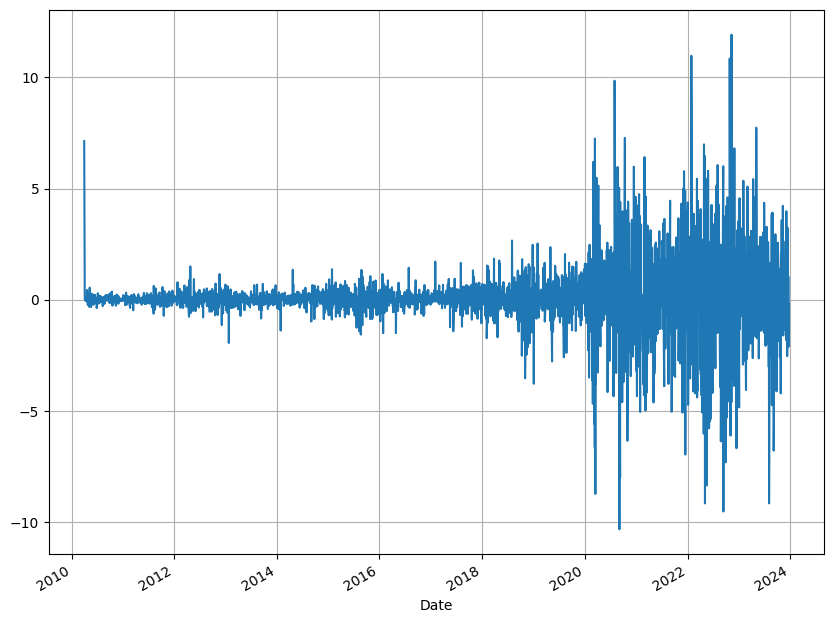

In [12]:
feature_selected.set_index('Date')['stock_demand'].plot(figsize=FIGURE_SIZE)

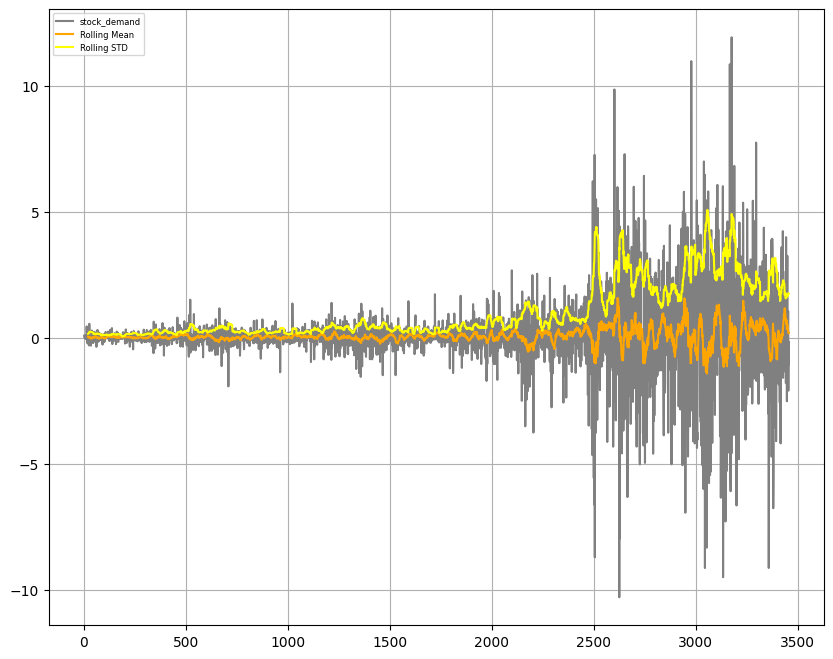

In [13]:
fig, ax = plt.subplots(figsize=(10, 8))
feature_selected['stock_demand'][1:].plot(c='grey')
feature_selected['stock_demand'][1:].rolling(20).mean().plot(label='Rolling Mean',c='orange')
feature_selected['stock_demand'][1:].rolling(20).std().plot(label='Rolling STD',c='yellow')
plt.legend(prop={'size': 6})

In [14]:
def kpss_test(series, **kw):
    statistic, p_value, n_lags, critical_values = kpss(series, **kw)
    # Format Output
    print(f'KPSS Statistic: {statistic}')
    print(f'p-value: {p_value}')
    print(f'num lags: {n_lags}')
    print('Critial Values:')
    for key, value in critical_values.items():
        print(f'   {key} : {value}')
    print(f'Result: The series is {"not " if p_value < 0.05 else ""}stationary')

kpss_test(feature_selected['stock_demand'])

KPSS Statistic: 0.32292620333854793
p-value: 0.1
num lags: 4
Critial Values:
   10% : 0.347
   5% : 0.463
   2.5% : 0.574
   1% : 0.739
Result: The series is stationary


In [15]:
def build_temporal_features(data: pd.DataFrame) -> pd.DataFrame:
    # Temporal features
    feature_selected['year'] = feature_selected['Date'].dt.year
    feature_selected['month'] = feature_selected['Date'].dt.month
    feature_selected['week'] = feature_selected['Date'].dt.week
    feature_selected['day'] = feature_selected['Date'].dt.day
    feature_selected['dayofweek'] = feature_selected['Date'].dt.dayofweek
    #data['quarter'] = data['date'].dt.quarter
    feature_selected['week_of_month'] = data['day'].apply(lambda x: np.ceil(x / 7)).astype(np.int8)
    feature_selected['is_weekend'] = (feature_selected['dayofweek'] > 5).astype(np.int8)

    return feature_selected

temporal_data = build_temporal_features(feature_selected)
temporal_data

,Date,Adj Close,stock_demand,year,month,week,day,dayofweek,week_of_month,is_weekend
0,2010-04-01,7.134717,7.134717,2010,4,13,1,3,1,0
1,2010-04-05,7.210913,0.076196,2010,4,14,5,0,1,0
2,2010-04-06,7.242660,0.031747,2010,4,14,6,1,1,0
3,2010-04-07,7.274709,0.032049,2010,4,14,7,2,1,0
4,2010-04-08,7.255055,-0.019654,2010,4,14,8,3,2,0
...,...,...,...,...,...,...,...,...,...,...
3452,2023-12-18,195.640350,-1.677872,2023,12,51,18,0,3,0
3453,2023-12-19,196.689026,1.048676,2023,12,51,19,1,3,0
3454,2023-12-20,194.581711,-2.107315,2023,12,51,20,2,3,0
3455,2023-12-21,194.431885,-0.149826,2023,12,51,21,3,3,0


(array([0. , 0.2, 0.4, 0.6, 0.8, 1. ]),
 [Text(0, 0.0, '0.0'),
  Text(0, 0.2, '0.2'),
  Text(0, 0.4, '0.4'),
  Text(0, 0.6000000000000001, '0.6'),
  Text(0, 0.8, '0.8'),
  Text(0, 1.0, '1.0')])

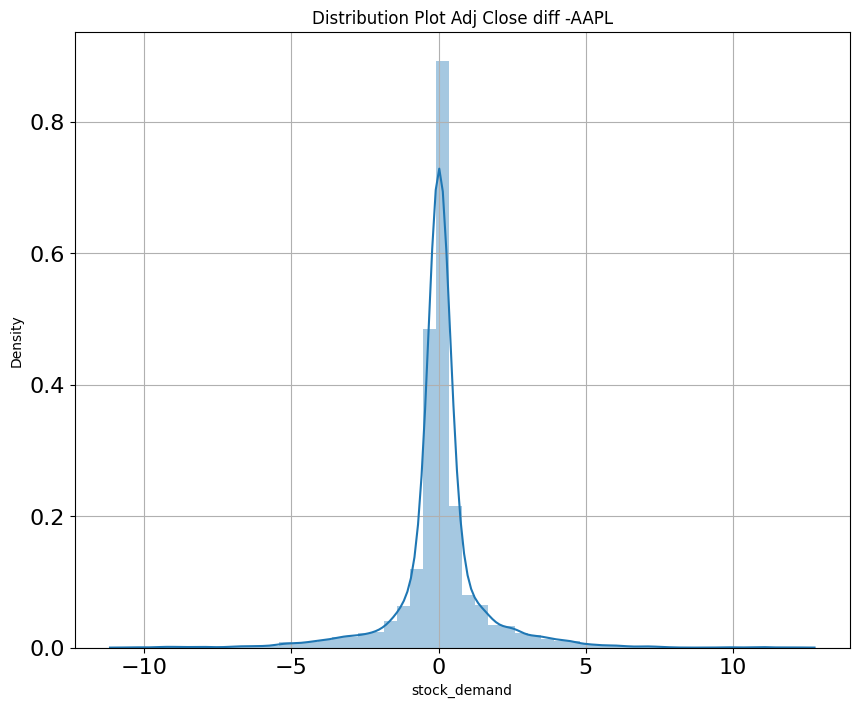

In [16]:
fig = plt.figure(figsize=(10,8))
sns.distplot(temporal_data['stock_demand']).set_title("Distribution Plot Adj Close diff -AAPL")
#ax.tick_params(labelsize=12)
sns.set(font_scale=1)
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)

In [17]:
temporal_data.to_csv("/content/gdrive/MyDrive/Stock Market Prediction - Time Series/apple_stock.csv", index=False)

In [18]:
stock_data = pd.read_csv('/content/gdrive/MyDrive/Stock Market Prediction - Time Series/apple_stock.csv')
stock_data.head()

,Date,Adj Close,stock_demand,year,month,week,day,dayofweek,week_of_month,is_weekend
0,2010-04-01,7.134717,7.134717,2010,4,13,1,3,1,0
1,2010-04-05,7.210913,0.076196,2010,4,14,5,0,1,0
2,2010-04-06,7.242660,0.031747,2010,4,14,6,1,1,0
3,2010-04-07,7.274709,0.032049,2010,4,14,7,2,1,0
4,2010-04-08,7.255055,-0.019654,2010,4,14,8,3,2,0


In [19]:
stock_data = stock_data.drop(axis=1, labels=['is_weekend'])
stock_data

,Date,Adj Close,stock_demand,year,month,week,day,dayofweek,week_of_month
0,2010-04-01,7.134717,7.134717,2010,4,13,1,3,1
1,2010-04-05,7.210913,0.076196,2010,4,14,5,0,1
2,2010-04-06,7.242660,0.031747,2010,4,14,6,1,1
3,2010-04-07,7.274709,0.032049,2010,4,14,7,2,1
4,2010-04-08,7.255055,-0.019654,2010,4,14,8,3,2
...,...,...,...,...,...,...,...,...,...
3452,2023-12-18,195.640350,-1.677872,2023,12,51,18,0,3
3453,2023-12-19,196.689026,1.048676,2023,12,51,19,1,3
3454,2023-12-20,194.581711,-2.107315,2023,12,51,20,2,3
3455,2023-12-21,194.431885,-0.149826,2023,12,51,21,3,3


## **Creating Training and Test Datasets**

In [20]:
# building the input variable
def create_dataset(dataset, time_step=1):
	dataX, dataY = [], []
	for i in range(len(dataset)-time_step-1):  # Time Series setps (0-99,100-200,,,,) any steps
		a = dataset[i:(i+time_step), 0]
		dataX.append(a)
		dataY.append(dataset[i + time_step, 0])
	return np.array(dataX), np.array(dataY)

def split_data(dataset, train_size):
  y = dataset['Adj Close']
  scaler = MinMaxScaler(feature_range=(0,1))
  y = scaler.fit_transform(np.array(y).reshape(-1,1))

  #Splitting data into train and test
  train_data, test_data = train_test_split(y, train_size=train_size, shuffle=False)

  # prepares the input features (dataX) and target variable (dataY) for training the time series model.
  time_step = 100
  X_train, y_train = create_dataset(train_data, time_step)
  X_test, y_test = create_dataset(test_data, time_step)

  X_train =X_train.reshape(X_train.shape[0],X_train.shape[1] , 1)
  X_test = X_test.reshape(X_test.shape[0],X_test.shape[1] , 1)

  return y, X_train, y_train, X_test, y_test, scaler


In [21]:
train_size = 0.65
y, X_train, y_train, X_test, y_test, scaler = split_data(stock_data, train_size)
print(X_train.shape)
print(y_train.shape)

(2146, 100, 1)
(2146,)


## **Helper Functions for building models**

In [22]:
def build_lstm():
  model=Sequential()
  # Adding first LSTM layer
  model.add(LSTM(150,return_sequences=True,input_shape=(100,1)))
  model.add(Dropout(0.2)) # Dropout regularisation
  # second LSTM layer
  model.add(LSTM(150,return_sequences=True))
  # Adding third LSTM layer
  model.add(LSTM(150, return_sequences=True))
  model.add(Dropout(0.2))
  # Adding fourth LSTM layer
  model.add(LSTM(150)) #  you can try 100 as well
  model.add(Dropout(0.2))
  # Adding the Output Layer
  model.add(Dense(1))
  model.compile(loss='mean_squared_error',optimizer='adam')

  return model

def build_bilstm():
  model = Sequential()
  model.add(Bidirectional(LSTM(100, activation='relu', input_shape=(100,1)))) #elu
  model.add(Dense(1))
  model.compile(loss='mean_squared_error', optimizer='adam') #rmsprop | adam
  return model

def fit_model(model, X_train, y_train, X_test, y_test):
  monitor = EarlyStopping(monitor='val_loss', min_delta=1e-3, patience=30, verbose=1, mode='auto', restore_best_weights=True)
  history = model.fit(X_train,y_train,validation_data=(X_test, y_test), callbacks=[monitor],verbose=1,epochs=100)

  return model, history

def plot_epoch_loss(history):
  plt.plot(history.history['loss'], 'o-', mfc='none', markersize=10, label='Train')
  plt.plot(history.history['val_loss'], 'o-', mfc='none', markersize=10, label='Valid')
  plt.title('Model loss')
  plt.ylabel('Loss')
  plt.xlabel('Epoch')
  plt.legend(['Train', 'Test'], loc='upper left')
  plt.show()

def predict(model, X_train, X_test, scaler):
  X_train_pred = model.predict(X_train)
  X_test_pred = model.predict(X_test)

  X_train_pred = scaler.inverse_transform(X_train_pred)
  X_test_pred = scaler.inverse_transform(X_test_pred)

  return X_train_pred, X_test_pred

def get_rmse(actual, predicted):
  return math.sqrt(mean_squared_error(actual, predicted))


## **Long Short Term Memory Model**

In [23]:
lstm = build_lstm()
lstm.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 100, 150)          91200     
                                                                 
 dropout (Dropout)           (None, 100, 150)          0         
                                                                 
 lstm_1 (LSTM)               (None, 100, 150)          180600    
                                                                 
 lstm_2 (LSTM)               (None, 100, 150)          180600    
                                                                 
 dropout_1 (Dropout)         (None, 100, 150)          0         
                                                                 
 lstm_3 (LSTM)               (None, 150)               180600    
                                                                 
 dropout_2 (Dropout)         (None, 150)               0

In [57]:
lstm, lstm_history = fit_model(lstm, X_train, y_train, X_test, y_test)
lstm.save('/content/gdrive/MyDrive/Stock Market Prediction - Time Series/lstm.h5')

Epoch 1/100
68/68 [==============================] - 71s 915ms/step - loss: 9.9910e-04 - val_loss: 0.0093
Epoch 2/100
68/68 [==============================] - 64s 946ms/step - loss: 9.7916e-05 - val_loss: 0.0114
Epoch 3/100
68/68 [==============================] - 61s 894ms/step - loss: 9.2065e-05 - val_loss: 0.0023
Epoch 4/100
68/68 [==============================] - 57s 847ms/step - loss: 8.7856e-05 - val_loss: 0.0089
Epoch 5/100
68/68 [==============================] - 58s 850ms/step - loss: 8.5067e-05 - val_loss: 0.0020
Epoch 6/100
68/68 [==============================] - 56s 832ms/step - loss: 7.6674e-05 - val_loss: 0.0023
Epoch 7/100
68/68 [==============================] - 56s 822ms/step - loss: 9.5236e-05 - val_loss: 0.0040
Epoch 8/100
68/68 [==============================] - 59s 864ms/step - loss: 8.7587e-05 - val_loss: 0.0046
Epoch 9/100
68/68 [==============================] - 56s 821ms/step - loss: 6.6565e-05 - val_loss: 0.0195
Epoch 10/100
68/68 [==========================

In [24]:
lstm = load_model('/content/gdrive/MyDrive/Stock Market Prediction - Time Series/lstm.h5')

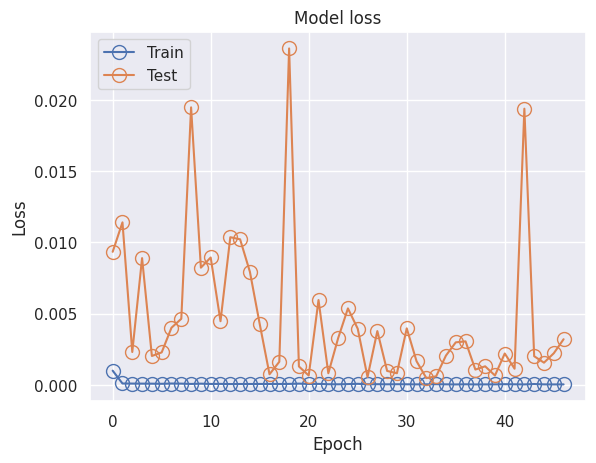

In [59]:
plot_epoch_loss(lstm_history)

In [25]:
X_train_pred_lstm, X_test_pred_lstm = predict(lstm, X_train, X_test, scaler)

35/35 [==============================] - 9s 250ms/step


In [26]:
train_error_lstm = get_rmse(y_train, X_train_pred_lstm)
test_error_lstm = get_rmse(y_test, X_test_pred_lstm)

print('Training Error: ', train_error_lstm)
print('Testing Error: ', test_error_lstm)

Training Error:  26.524805462357648
Testing Error:  135.21340605537287


In [27]:
def calc_plot_predictions(y, lookback):
  predict_plot = np.empty_like(y)
  predict_plot[:, :] = np.nan
  return predict_plot

lookback = 100
train_predict_plot_lstm = calc_plot_predictions(y, lookback)
train_predict_plot_lstm[lookback:len(X_train_pred_lstm)+lookback, :] = X_train_pred_lstm

test_predict_plot_lstm = calc_plot_predictions(y, lookback)
test_predict_plot_lstm[len(X_train_pred_lstm)+(lookback*2)+1:len(y)-1, :] = X_test_pred_lstm

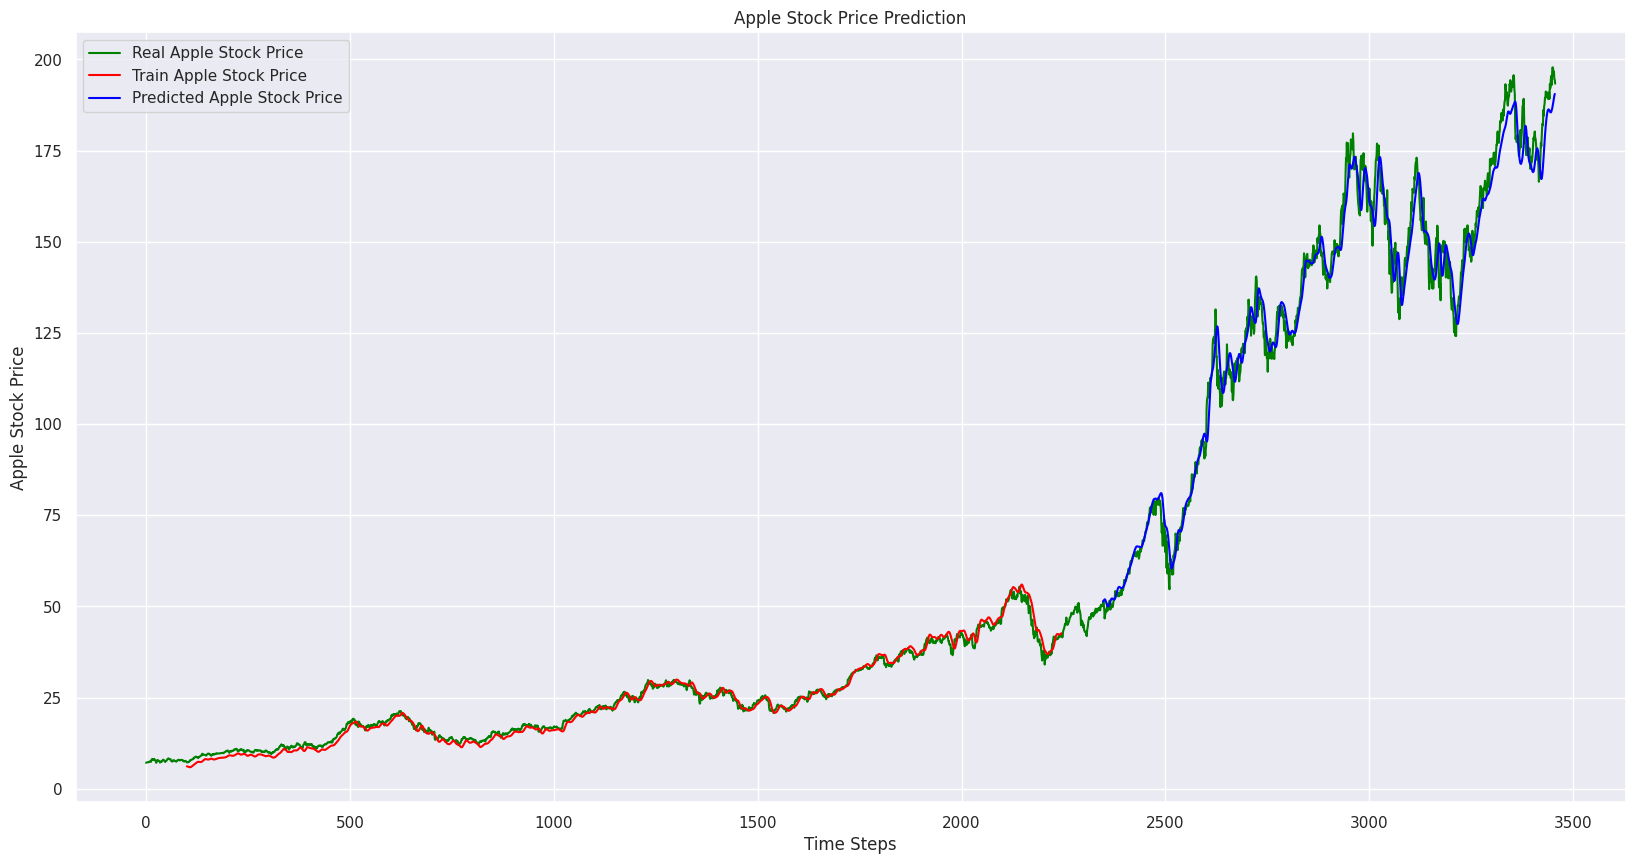

In [28]:
fig, ax = plt.subplots(figsize=(20,10))
plt.plot(scaler.inverse_transform(y), color='Green', label='Real Apple Stock Price')
plt.plot(train_predict_plot_lstm, color='Red', label='Train Apple Stock Price')
plt.plot(test_predict_plot_lstm, color='Blue', label='Predicted Apple Stock Price')

plt.title('Apple Stock Price Prediction')
plt.xlabel('Time Steps')
plt.ylabel('Apple Stock Price')
plt.legend()
plt.show()

## **BiLSTM**

In [29]:
bilstm = build_bilstm()

In [30]:
bilstm, bilstm_history = fit_model(bilstm, X_train, y_train, X_test, y_test)
bilstm.save('/content/gdrive/MyDrive/Stock Market Prediction - Time Series/bilstm.h5')

Epoch 1/100
68/68 [==============================] - 11s 108ms/step - loss: 0.0011 - val_loss: 0.0083
Epoch 2/100
68/68 [==============================] - 9s 127ms/step - loss: 7.1465e-05 - val_loss: 0.0313
Epoch 3/100
68/68 [==============================] - 7s 108ms/step - loss: 4.9034e-05 - val_loss: 0.0203
Epoch 4/100
68/68 [==============================] - 8s 119ms/step - loss: 3.9993e-05 - val_loss: 0.0085
Epoch 5/100
68/68 [==============================] - 8s 123ms/step - loss: 3.1215e-05 - val_loss: 0.0157
Epoch 6/100
68/68 [==============================] - 7s 104ms/step - loss: 2.3876e-05 - val_loss: 0.0015
Epoch 7/100
68/68 [==============================] - 9s 128ms/step - loss: 2.4475e-05 - val_loss: 0.0012
Epoch 8/100
68/68 [==============================] - 7s 101ms/step - loss: 1.8641e-05 - val_loss: 0.0010
Epoch 9/100
68/68 [==============================] - 8s 125ms/step - loss: 1.8313e-05 - val_loss: 0.0041
Epoch 10/100
68/68 [==============================] - 7s 1

In [31]:
bilstm = load_model('/content/gdrive/MyDrive/Stock Market Prediction - Time Series/bilstm.h5')

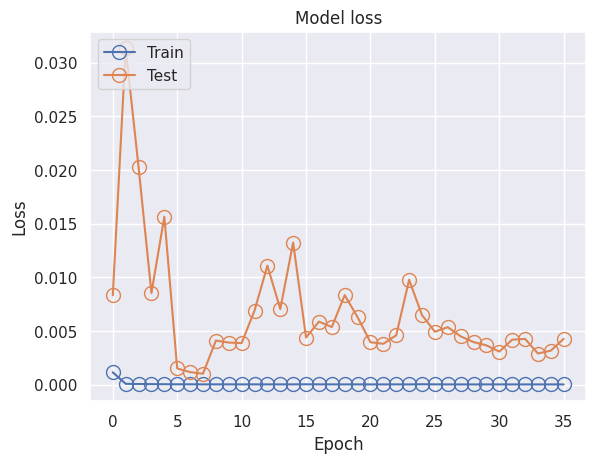

In [32]:
plot_epoch_loss(bilstm_history)

In [33]:
X_train_pred_bilstm, X_test_pred_bilstm = predict(bilstm, X_train, X_test, scaler)

35/35 [==============================] - 1s 27ms/step


In [34]:
train_error_bilstm = get_rmse(y_train, X_train_pred_bilstm)
test_error_bilstm = get_rmse(y_test, X_test_pred_bilstm)

print('Training Error: ', train_error_bilstm)
print('Testing Error: ', test_error_bilstm)

Training Error:  25.740018430596137
Testing Error:  138.96482727032364


In [35]:
def evaluate_predictions(predictions, y_test, outliers):
    ratio = []
    differences = []
    for pred in range(len(y_test)):
        ratio.append((y_test[pred]/predictions[pred])-1)
        differences.append(abs(y_test[pred]- predictions[pred]))

    n_outliers = int(len(differences) * outliers)
    outliers = pd.Series(differences).astype(float).nlargest(n_outliers)

    return ratio, differences, outliers

# create the list of difference between prediction and test data
predictions = bilstm.predict(X_test)
ratio, differences, outliers = evaluate_predictions(predictions, y_test, 0.01)
for index in outliers.index:
    outliers[index] = predictions[index]

35/35 [==============================] - 1s 36ms/step


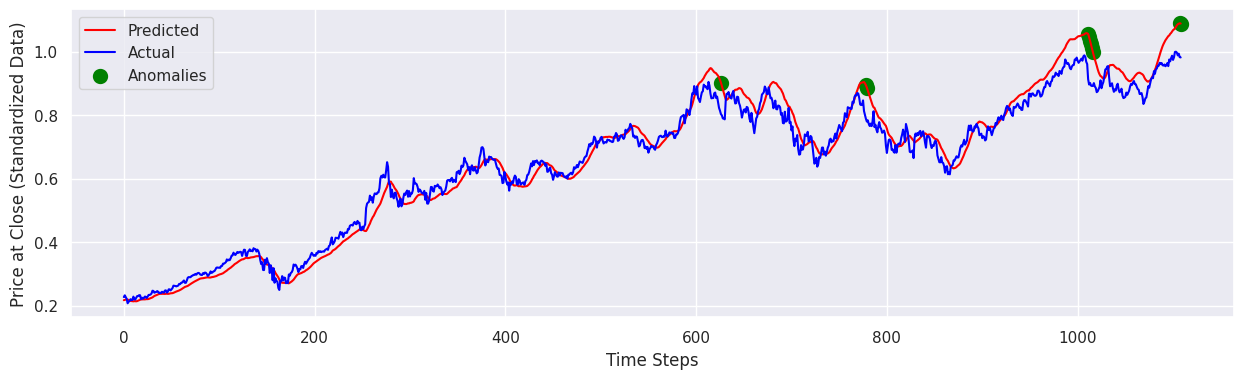

In [36]:
# Showing the predicted vs. actual values
fig, axs = plt.subplots()
fig.set_figheight(4)
fig.set_figwidth(15)

axs.plot(predictions,color='red', label='Predicted')
axs.plot(y_test,color='blue', label='Actual')
axs.scatter(outliers.index,outliers, color='green', linewidth=5.0, label='Anomalies')
plt.xlabel('Time Steps')
plt.ylabel('Price at Close (Standardized Data)')
plt.legend(loc='upper left')
plt.show()

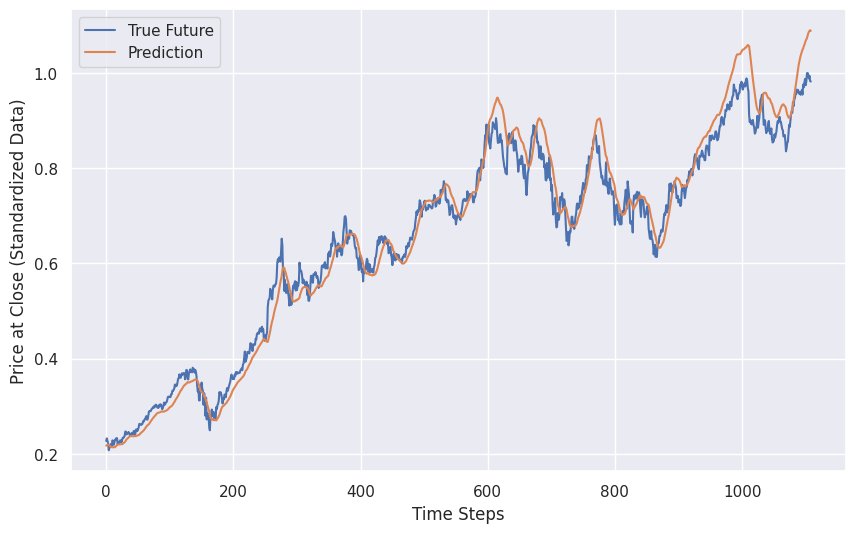

In [37]:
# Plot true future vs prediction
plt.figure(figsize=(10, 6))
range_future = len(predictions)
plt.plot(np.arange(range_future), np.array(y_test), label='True Future')
plt.plot(np.arange(range_future),np.array(predictions), label='Prediction')
plt.legend(loc='upper left')
plt.xlabel('Time Steps')
plt.ylabel('Price at Close (Standardized Data)')
plt.show()